<center>
    <h1>Mohamed Nasser Aboelnasr</h1>
</center>

## Task 1 

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

### Streaming from TCP Socket


In [4]:
df = spark.readStream.format('socket')\
.option('host', 'localhost')\
.option('port', 12345)\
.load()

### Print Schema

In [5]:
df.printSchema()

root
 |-- value: string (nullable = true)



### After processing, you can write the DataFrame to console.

In [6]:
writer = df.writeStream.outputMode('append')\
.format('console')

In [ ]:
query = writer.start()
query.awaitTermination()

In [ ]:
query.stop()

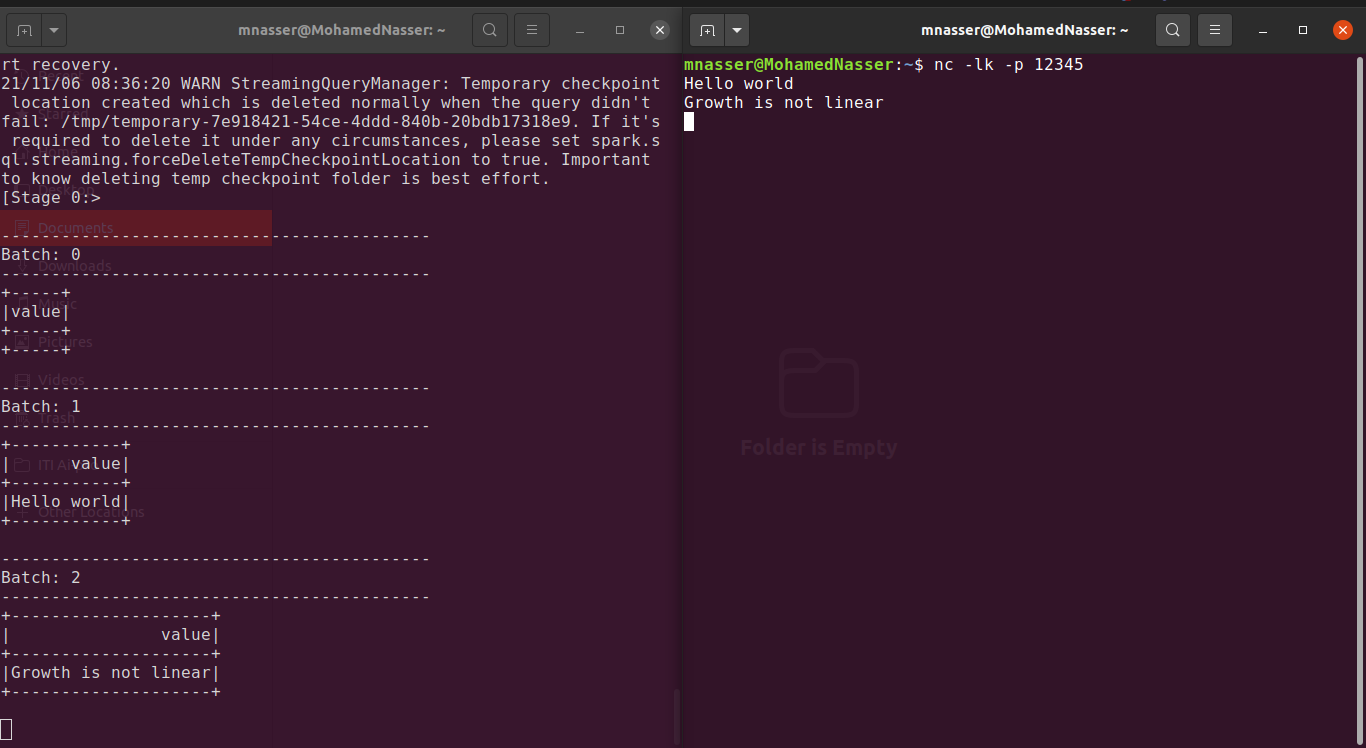

## Task 2

let’s create a streaming DataFrame that represents text data received from a server listening on localhost:9999, and transform the DataFrame to calculate word counts.

### Create DataFrame representing the stream of input lines from connection to localhost:9999


In [4]:
df2 = spark.readStream.format("socket")\
.option("host", "localhost")\
.option("port", 9999)\
.load()

### Split the lines into words


In [5]:
from pyspark.sql.functions import *

In [6]:
words = df2.select(explode(split(df2.value, " ")).alias("word"))

### Generate running word count


In [7]:
wordCounts = words.groupBy("word").count()

### Start running the query that prints the running counts to the console


In [8]:
writer2 = wordCounts.writeStream\
.format("console")\
.outputMode("complete")

In [ ]:
query2 = writer2.start()
query2.awaitTermination()

In [ ]:
query2.stop()

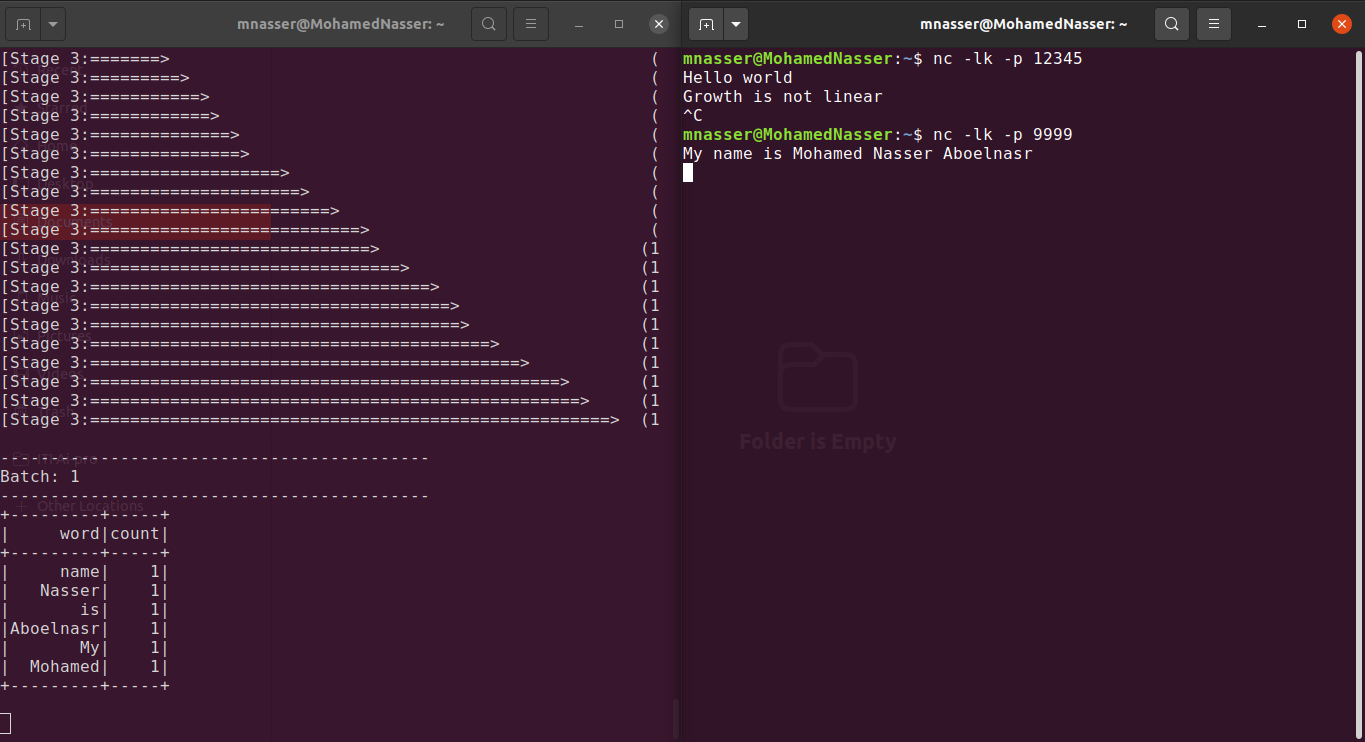

### Read csv file "test1.csv"

In [20]:
inputDirectory = '/home/mnasser/ITI\ Ai-pro/PySpark/Day\ 3\&4/Day\ 3\&4\ Assignment/'

In [21]:
from pyspark.sql.types import *

recordSchema = StructType([StructField('Name', StringType(), True),
                           StructField('Departments', StringType(), True),
                           StructField('salary', IntegerType(), True)])

In [22]:
df3 = spark.readStream.format("csv")\
.schema(recordSchema)\
.load(inputDirectory)

### Writing Spark Streaming to Console


In [23]:
outputDirectory = '/home/mnasser/ITI\ Ai-pro/PySpark/Day\ 3\&4/Day\ 3\&4\ Assignment/output'

In [25]:
writer3 = df3.writeStream.outputMode("append")\
.format("csv")\
.option("path", outputDirectory)\
.option("checkpointLocation", "chkpnt")

In [ ]:
query3 = writer3.start()
query3.awaitTermination()

In [ ]:
query3.stop()

## Task 3 

#### Creat GraphFrames
Users can create GraphFrames from vertex and edge DataFrames.

Vertex DataFrame: A vertex DataFrame should contain a special column named "id" which specifies unique IDs for each vertex in the graph.
Edge DataFrame: An edge DataFrame should contain two special columns: "src" (source vertex ID of edge) and "dst" (destination vertex ID of edge).
Both DataFrames can have arbitrary other columns. Those columns can represent vertex and edge attributes.

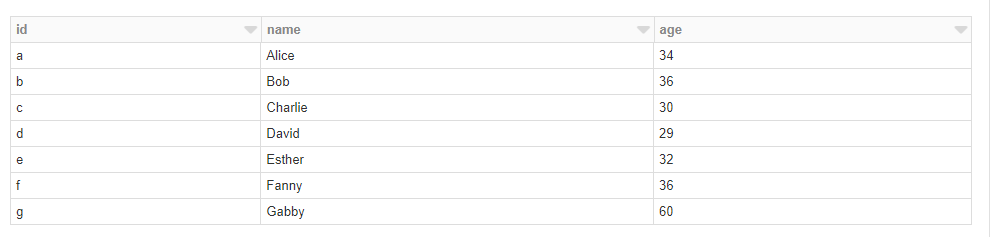

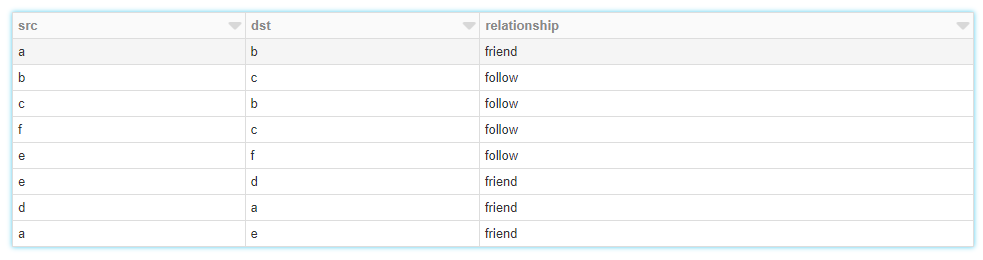

In [27]:
vertices = spark.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
  ("d", "David", 29),
  ("e", "Esther", 32),
  ("f", "Fanny", 36),
  ("g", "Gabby", 60)
], ["id", "name", "age"])

In [28]:
edges = spark.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
  ("f", "c", "follow"),
  ("e", "f", "follow"),
  ("e", "d", "friend"),
  ("d", "a", "friend"),
  ("a", "e", "friend")
], ["src", "dst", "relationship"])

### Create a graph from these vertices and these edges:

In [29]:
sc = spark.sparkContext
sc.addPyFile('/opt/spark/jars/graphframes-0.8.2-spark3.0-s_2.12.jar')

In [30]:
from graphframes import GraphFrame

In [31]:
g = GraphFrame(vertices, edges)

In [32]:
import networkx as nx
import matplotlib.pyplot as plt

In [33]:
def PlotGraph(edge_list):
    Gplot=nx.Graph()
    for row in edge_list.select('src','dst').take(50):
        Gplot.add_edge(row['src'],row['dst'])

    plt.subplot(121)
    nx.draw(Gplot, with_labels=True, font_weight='bold')

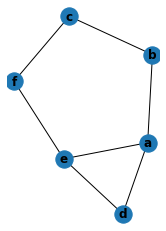

In [34]:
PlotGraph(g.edges)

### Display vertices

In [35]:
g.vertices.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
|  g|  Gabby| 60|
+---+-------+---+



### Display edges

In [36]:
g.edges.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
+---+---+------------+



### Display inDegrees


In [37]:
g.inDegrees.show()

+---+--------+
| id|inDegree|
+---+--------+
|  f|       1|
|  e|       1|
|  d|       1|
|  c|       2|
|  b|       2|
|  a|       1|
+---+--------+



### Display the outgoing degree of the vertices:



In [38]:
g.outDegrees.show()

+---+---------+
| id|outDegree|
+---+---------+
|  f|        1|
|  e|        2|
|  d|        1|
|  c|        1|
|  b|        1|
|  a|        2|
+---+---------+



### Display the degree of the vertices:



In [39]:
g.degrees.show()

+---+------+
| id|degree|
+---+------+
|  f|     2|
|  e|     3|
|  d|     2|
|  c|     3|
|  b|     3|
|  a|     3|
+---+------+



### Find the age of the youngest person in the graph

In [40]:
from pyspark.sql.functions import *
g.vertices.select(min('age')).show()

+--------+
|min(age)|
+--------+
|      29|
+--------+



### Count the number of 'follow' relationships in the graph:

In [41]:
g.edges.filter("relationship = 'follow'").count()

4

### Motif finding


Search for pairs of vertices with edges in both directions between them.

In [42]:
motif = g.find("(v1)-[e1]->(v2);(v2)-[e2]->(v1)")
motif.show()

+----------------+--------------+----------------+--------------+
|              v1|            e1|              v2|            e2|
+----------------+--------------+----------------+--------------+
|[c, Charlie, 30]|[c, b, follow]|    [b, Bob, 36]|[b, c, follow]|
|    [b, Bob, 36]|[b, c, follow]|[c, Charlie, 30]|[c, b, follow]|
+----------------+--------------+----------------+--------------+



find all the reciprocal relationships in which one person is older than 30:

In [43]:
motif2 = g.find("(v1)-[]->(v2)")
motif2.filter("v1.age > 30").distinct().show()

+---------------+----------------+
|             v1|              v2|
+---------------+----------------+
| [a, Alice, 34]| [e, Esther, 32]|
|[e, Esther, 32]|  [d, David, 29]|
|[e, Esther, 32]|  [f, Fanny, 36]|
| [a, Alice, 34]|    [b, Bob, 36]|
|   [b, Bob, 36]|[c, Charlie, 30]|
| [f, Fanny, 36]|[c, Charlie, 30]|
+---------------+----------------+



### Explore some patterns from your choice using Motifs

In [47]:
motif3 = g.find("(v1)-[]->(v2);(v2)-[]->(v3);(v3)-[]->(v1)")
motif3.show()

+---------------+---------------+---------------+
|             v1|             v2|             v3|
+---------------+---------------+---------------+
| [d, David, 29]| [a, Alice, 34]|[e, Esther, 32]|
| [a, Alice, 34]|[e, Esther, 32]| [d, David, 29]|
|[e, Esther, 32]| [d, David, 29]| [a, Alice, 34]|
+---------------+---------------+---------------+



In [48]:
motif3.filter("v1.age > 30 and v1.age < v3.age").distinct().show()

+---------------+--------------+--------------+
|             v1|            v2|            v3|
+---------------+--------------+--------------+
|[e, Esther, 32]|[d, David, 29]|[a, Alice, 34]|
+---------------+--------------+--------------+

